In [1]:
from rclpy.node import Node
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import cv2
from PIL import Image as PILImage, PngImagePlugin
import io

class ImageSubscriber(Node):
    def __init__(self):
        super().__init__('image_subscriber')
        self.subscription = self.create_subscription(
            Image,
            '/camera/camera/color/image_raw',  # Change this to your image topic
            self.image_callback,
            10)
        self.subscription  # prevent unused variable warning
        self.bridge = CvBridge()
        self.pil_image = None
        self.cv_image = None
        self.png_image = None

    def image_callback(self, msg):
        cv_image = self.bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
        rgb_image = cv2.cvtColor(cv_image,cv2.COLOR_BGR2RGB)
        self.cv_image = rgb_image  # Store OpenCV image for later use
        self.pil_image = PILImage.fromarray(cv_image)

        # buffer = io.BytesIO()
        # self.pil_image.save(buffer, format='PNG')

        # buffer.seek(0)
        # self.png_image = PngImagePlugin.PngImageFile(buffer)

        # cv2.imshow("Image Window", self.cv_image)
        # cv2.waitKey(100)  # Wait for a key press for 1 millisecond

In [2]:

import rclpy
import rclpy.logging
from rclpy.executors import MultiThreadedExecutor
import cv2
import torch
import time
import numpy as np

rclpy.init(args=None)
image_subscriber = ImageSubscriber()

from utils import *
rscalc = RealSensePointCalculator()

executor = MultiThreadedExecutor()
executor.add_node(image_subscriber)
executor.add_node(rscalc)


True

In [3]:
try:
    while rclpy.ok():
        print(1)
        executor.spin_once(timeout_sec=0.1)
        if image_subscriber.pil_image is not None:
            print(2)
            pil_image = image_subscriber.pil_image
            if rscalc.info_received():
                break
        time.sleep(0.1)
        print(3)

except KeyboardInterrupt:
    pass

finally:
    pass

1
3
1
3
1
3
1
2


In [4]:
ct = rscalc.get_clock().now().nanoseconds * 1e-9
print(ct)


1731411225.6695995


(640, 480)


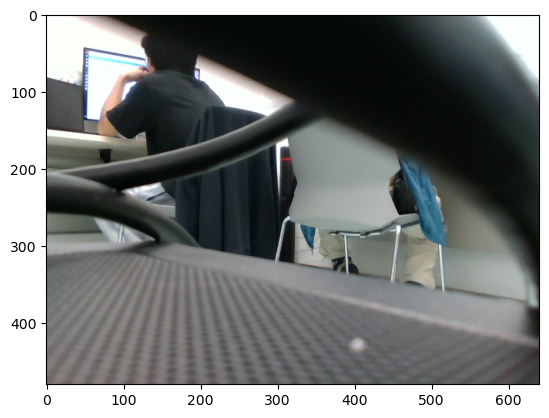

In [5]:
print(pil_image.size)
# display the image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(pil_image)
# plt.imshow(image[0].permute(1, 2, 0).cpu())

In [6]:
# Before running this, add lang-seg folder to your python path
from LoadLSeg import *
import torchvision.transforms as transforms
# from PIL import Image # use PILImage instead
from test_lseg_zs import *

transform = transforms.Compose([
    transforms.Resize(480),           # Resize the shorter side to 480 while maintaining aspect ratio
    transforms.CenterCrop((480, 480)),  # Crop the center to 480x480
    transforms.ToTensor()            # Convert to tensor
])

image_tensor = transform(pil_image)
image_tensor.shape

/home/fyp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(model='encnet', backbone='clip_vitl16_384', dataset='fss', workers=16, base_size=520, crop_size=480, train_split='train', aux=False, se_loss=False, se_weight=0.2, batch_size=16, test_batch_size=16, no_cuda=False, seed=1, weights='/home/fyp/lang-seg/checkpoints/demo_e200.ckpt', eval=False, acc_bn=False, test_val=False, no_val=False, module='clipseg_DPT_test_v2', scale_inv=False, widehead=True, widehead_hr=False, ignore_index=255, jobname='default', strict=True, use_pretrained='True', arch_option=0, nshot=0, fold=0, nworker=0, bsz=1, benchmark='pascal', datapath='data/Datasets_HSN', activation='relu', cuda=True)


/home/fyp/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint checkpoints/demo_e200.ckpt`
/home/fyp/lang-seg/modules/lsegmentation_module_zs.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler(enabled=self.enabled)

:=========== Few-shot Seg. with HSNet ===========
|             datapath: data/Datasets_HSN       
|       

use norm: [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
['ac_wall', 'acorn', 'adhensive_tape', 'adidas_logo1', 'adidas_logo2', 'afghan_hound', 'african_elephant', 'african_grey', 'agama', 'air_strip', 'aircraft_carrier', 'airedale', 'airship', 'almond', 'ambulance', 'american_staffordshire', 'anemone_fish', 'angora', 'apple', 'armour', 'ashtray', 'assult_rifle', 'aubergine', 'avocado', 'baboon', 'backpack', 'bagel', 'balance_weight', 'bald_eagle', 'ballpoint', 'banana', 'band-aid', 'banded_gecko', 'barometer', 'baseball_bat', 'baseball_player', 'basketball', 'bassoon', 'bathtub', 'battery', 'beacon', 'beaker', 'beam_bridge', 'bear', 'beaver', 'bedlington_terrier', 'bee_house', 'besom', 'birdhouse', 'bison', 'black_grouse', 'black_stork', 'black_swan', 'blossom_card', 'boa_constrictor', 'bolotie', 'bomb', 'border_terrier', 'boston_bull', 'bottle_cap', 'bouzouki', 'box_turtle', 'bra', 'bracelet', 'bradypod', 'brain_coral', 'brambling', 'brasscica', 'brick', 'brick_card', 'brick_tea', 'briefcase', 'br

torch.Size([3, 480, 480])

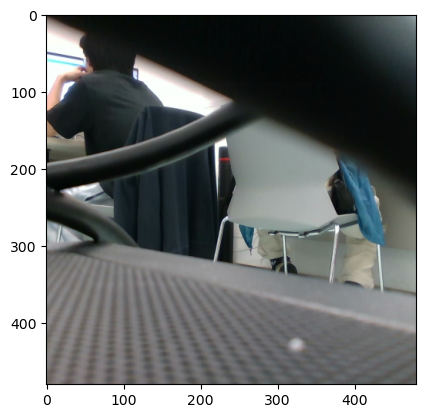

In [7]:
plt.imshow(image_tensor.permute(1, 2, 0))

In [8]:
torch.cuda.empty_cache()
with torch.no_grad():
    feat = model(image_tensor.unsqueeze(0).cuda())
feat.shape

torch.Size([480, 480, 512])

In [ ]:
search = "blue bottle"
threshold = 0.99
text_feat1 = model.encode_text(search)
sim_image = feat.half() @ text_feat1.t()
sim_image[sim_image < sim_image.max()*threshold] = 0
display_img2 = sim_image.detach().cpu().numpy()
plt.imshow(display_img2, cmap='gray', vmin=display_img2.min(), vmax=display_img2.max())
# coordinates of the maximum value in the similarity image
print("###############################################")
print(f"searching for: {search}")
print("###############################################")
x, y = float((sim_image.argmax() // sim_image.shape[1]).detach().cpu()), float((sim_image.argmax() % sim_image.shape[1]).detach().cpu())
print("max value at (coordinate in pixel):", f"row {x}", f"col {y}")
print("max value at (coordinate %):", round(x/480,2), round(y/480, 2))

In [ ]:
# print(feat_image[350, 350])
# print(feat_image.min())

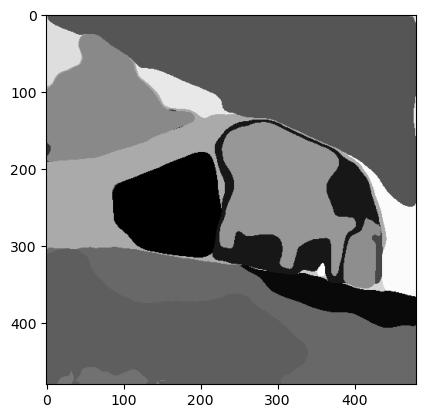

In [9]:
clustered_image = PCA_and_Cluster(feat)
plt.imshow(clustered_image, cmap='gray', vmin=clustered_image.min(), vmax=clustered_image.max())

In [10]:
key_pixels = obtain_key_pixels(feat, clustered_image)

In [11]:
key_points = rscalc.obtain_key_points(key_pixels)

In [22]:
print(len(key_points))
print(type(key_points[0][1][0]))
print(key_points[0][1][3])

15
<class 'numpy.float64'>


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
n = min(30, len(class_pixel[0]))
indices = np.random.choice(len(class_pixel[0]), n, replace=False)

In [ ]:
indices

In [ ]:

executor.shutdown()
image_subscriber.destroy_node()
rscalc.destroy_node()
rclpy.shutdown()